In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from datetime import date, datetime
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.style.use('seaborn-deep')

## Definition of censoring and death

Quitting is death, all else is censoring. This is different than the [original article](https://fivethirtyeight.com/features/two-years-in-turnover-in-trumps-cabinet-is-still-historically-high/)'s author's rules, who stated that switching roles _within_ a cabinent is an "event". 

In [2]:
raw_df = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/cabinet-turnover/cabinet-turnover.csv",
                    na_values=['Still in office', '#VALUE!']
                    )
TODAY = datetime.today().date()

INAUG_DATES = {
    'Trump': date(2017, 1, 20),
    'Obama': date(2009, 1, 20),
    'Bush 43': date(2001, 1, 20),
    'Clinton': date(1993, 1, 20),
    'Bush 41': date(1989, 1, 20),
    'Reagan': date(1981, 1, 20),
    'Carter': date(1977, 1, 20)
}

presidential_terms = pd.DataFrame(list(INAUG_DATES.items()))
presidential_terms.columns = ['president', 'president_start_date']
presidential_terms['president_end_date'] = presidential_terms['president_start_date'].shift(1).fillna(TODAY)
presidential_terms

,president,president_start_date,president_end_date
0,Trump,2017-01-20,2020-07-12
1,Obama,2009-01-20,2017-01-20
2,Bush 43,2001-01-20,2009-01-20
3,Clinton,1993-01-20,2001-01-20
4,Bush 41,1989-01-20,1993-01-20
5,Reagan,1981-01-20,1989-01-20
6,Carter,1977-01-20,1981-01-20


In [3]:
def fill_end(series):
    end, president = series
    if pd.notnull(end) and end.endswith('admin'):
        next_pres ,_ = end.split(' ')
        if next_pres == 'Bush':
            next_pres = next_pres + ' 43' if president == 'Clinton' else next_pres + ' 41'
        return INAUG_DATES[next_pres].strftime('%m/%d/%y')
    else:
        return end
    
def fill_start(series):
    end, president = series
    if pd.notnull(end) and end.endswith('admin'):
        prev_pres ,_ = end.split(' ')
        if prev_pres == 'Bush':
            prev_pres = prev_pres + ' 43' if president == 'Obama' else prev_pres + ' 41'
        return INAUG_DATES[president].strftime('%m/%d/%y')
    else:
        return end
    
    
raw_df['end'] = raw_df[['end', 'president']].apply(fill_end, axis=1)
raw_df['start'] = raw_df[['start', 'president']].apply(fill_start, axis=1)

raw_df['end'] = pd.to_datetime(raw_df['end']).dt.date
raw_df['end'] = raw_df['end'].fillna(TODAY)
raw_df['start'] = pd.to_datetime(raw_df['start']).dt.date

In [4]:
raw_df = raw_df.merge(presidential_terms, left_on='president', right_on='president')
raw_df['event'] = (raw_df['end'] < raw_df['president_end_date']) & pd.notnull(raw_df['end'])


In [5]:
# we need to "collapse" individuals into rows, because they may change positions, but that's not quitting...
def collapse(df):
    return df.groupby('appointee', as_index=False).aggregate({
        'start': 'min', 'end': 'max', 'event': 'all', 'president': 'last', 'president_end_date': 'last'
    })

raw_df = raw_df.groupby('president', as_index=False).apply(collapse).reset_index(drop=True)
raw_df['T'] = (raw_df['end'] - raw_df['start']).dt.days


In [6]:
raw_df.tail(20)

,appointee,start,end,event,president,president_end_date,T
267,Jeff Sessions,2017-02-09,2018-11-07,True,Trump,2020-07-12,636
268,Jim Mattis,2017-01-20,2018-12-31,True,Trump,2020-07-12,710
269,John Kelly,2017-01-20,2018-12-31,True,Trump,2020-07-12,710
270,Kirstjen Nielsen,2017-12-06,2020-07-12,False,Trump,2020-07-12,949
271,Linda McMahon,2017-02-14,2020-07-12,False,Trump,2020-07-12,1244
272,Mick Mulvaney,2017-02-16,2020-07-12,False,Trump,2020-07-12,1242
273,Mike Pence,2017-01-20,2020-07-12,False,Trump,2020-07-12,1269
274,Mike Pompeo,2017-01-23,2020-07-12,False,Trump,2020-07-12,1266
275,Nikki Haley,2017-01-27,2018-12-31,True,Trump,2020-07-12,703
276,Reince Priebus,2017-01-20,2017-07-28,True,Trump,2020-07-12,189


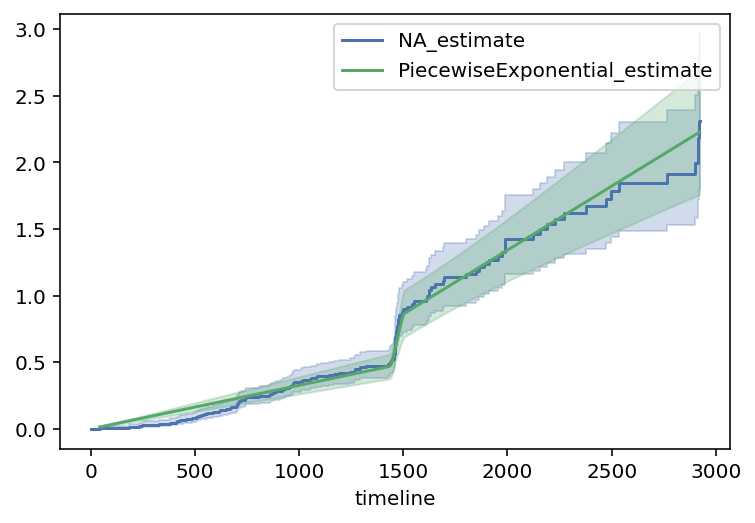

In [7]:
naf = NelsonAalenFitter()
ax = naf.fit(raw_df['T'],raw_df['event']).plot()

from lifelines import PiecewiseExponentialFitter
pf = PiecewiseExponentialFitter(breakpoints=[1440, 1500])
pf.fit(raw_df['T'], raw_df['event'])
pf.plot(ax=ax)
pf.print_summary(4)

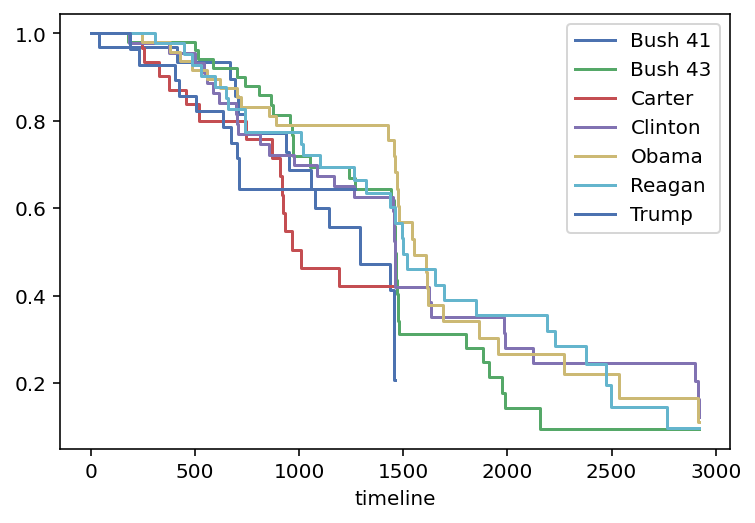

In [8]:
kmf = KaplanMeierFitter()

ax = plt.subplot()

for name, df_ in raw_df[['president','event', 'T']].groupby('president'):
    kmf.fit(df_['T'], df_['event'], label=name)
    ax = kmf.plot(ax=ax, ci_show=False)


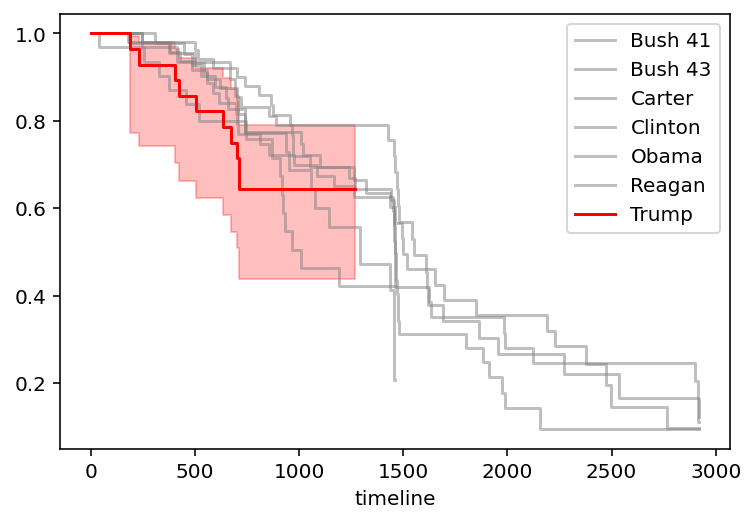

In [9]:
ax = plt.subplot()

for name, df_ in raw_df[['president','event', 'T']].groupby('president'):
    kmf.fit(df_['T'], df_['event'], label=name)
    if name == 'Trump':
        ax = kmf.plot(ax=ax, color='r')
    else:
        ax = kmf.plot(ax=ax, color='grey', alpha=0.5, ci_show=False)


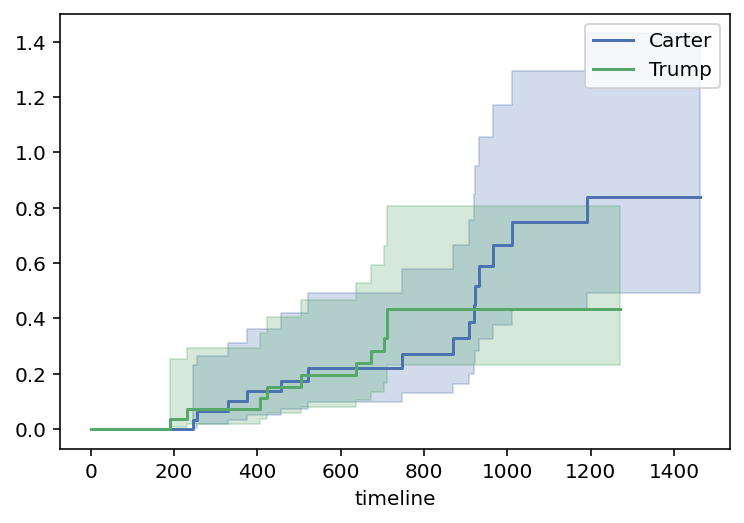

In [10]:
raw_df[['president','event', 'T']]

naf = NelsonAalenFitter()

ax = plt.subplot()

for name, df_ in raw_df[['president','event', 'T']].groupby('president'):
    if name in ['Trump', 'Carter']:
        naf.fit(df_['T'], df_['event'], label=name)
        ax = naf.plot(ax=ax)

In [11]:
raw_df['year'] = raw_df['start'].apply(lambda d: int(d.year))

regression_df = raw_df[['president', 'T', 'event', 'year']]


In [12]:
cph = CoxPHFitter()
cph.fit(regression_df, 'T', 'event', formula="president + bs(year, df=3)")
cph.print_summary(3)

In [13]:
cph.check_assumptions(regression_df)

Proportional hazard assumption looks okay.


> /Users/camerondavidson-pilon/code/lifelines/lifelines/fitters/coxph_fitter.py(2134)plot_covariate_groups()
-> getattr(self, "predict_%s" % y)(X).plot(ax=axes, **kwargs)
(Pdb) c


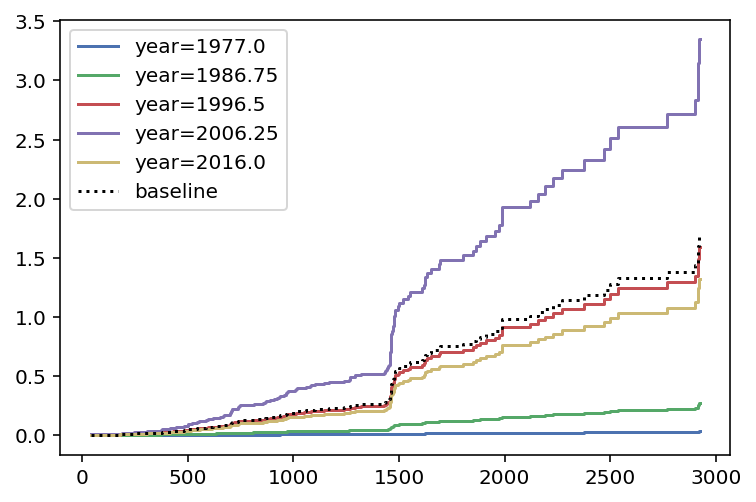

In [21]:
cph.plot_covariate_groups("year", values=np.linspace(1977, 2016, 5), y="cumulative_hazard")

In [15]:
from lifelines import *

wf = WeibullAFTFitter(penalizer=0.0)
wf.fit(regression_df, 'T', 'event')
wf.print_summary(3)

In [16]:
lnf = LogNormalAFTFitter(penalizer=0.0000)
lnf.fit(regression_df, 'T', 'event')
lnf.print_summary(3)

In [17]:
llf = LogLogisticAFTFitter(penalizer=0.000)
llf.fit(regression_df, 'T', 'event')
llf.print_summary(3)